# <b>NBA Regular Season Record Predictions</b>

This notebook attempts to use machine learning to anticipate the amount of success an NBA team will achieve in a future season based on their stats from the previous season. Three metrics are used to quantify success: the number of regular season wins the team finishes with, the rank they finish at with respect to their conference, and whether or not the team made the playoffs to continue into the postseason. These stats were congregated from various websites, including NBA Miner, Basketball Reference, and Real GM. Most are traditional statistics including points, assists, percentages, while others are more advanced and miscellaneous. From Real GM, the data was taken from the starters of each respective team, with the stats scaled per 48 minutes of gameplay. 

In addition, Pro Sports Transactions was used in an attempt to quantify offseason moves teams made that could potentially improve their roster or hinder their ability to succeed in the regular season. Here, the offseason is defined as the start of June to the end of October. The features derived from this website include: "Player Signings", the number of players a team signed who had played on another team the year before; "Large Player Signings", the number of players a team signed with a contract worth 10% of the NBA salary cap per year; "Draft Picks", the number of draft picks of the team that year; "Top 10 Draft Picks", which is self explanatory; and "Trades", the number of trades a team made during the offseason.

The data for each team is recorded in one individual excel sheet for that specific NBA season, starting from the 2000-2001 regular season to the 2015-2016 regular season. The model obtained from these datasets is to be applied to the stats from the 2016-2017 season to predict the 2017-2018 season. Because the stats from teams in the 2017-2018 NBA season are obviously unknown prior to the start, this notebook attempts to use machine learning that creates models from stats of the previous season to predict what happens in the next regular season.

Note that the wins for each team in the 2011-2012 regular season were scaled accordingly because that was the year of the NBA lockout, meaning only 66 games were played that year instead of 82. 

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# sklearn imports
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPClassifier

#miscellaneous imports
import random as rnd
import operator

First, each team name musted be mapped to a franchise number, to make up for the fact that franchises change mascots or rebrand. This also helps in creating each data set. Note that since the data has only been taken from the 2000-2001 season onwards, no franchise names of existing teams prior to this season are included.

In [2]:
team_map = {"Washington Wizards": 0, "Utah Jazz": 1, "Toronto Raptors": 2, "San Antonio Spurs": 3, 
       "Sacramento Kings": 4, "Portland Trailblazers": 5, "Phoenix Suns": 6, "Philadelphia 76ers": 7, 
       "Orlando Magic": 8, "Oklahoma City Thunder": 9, "New York Knicks": 10, "New Orleans Pelicans": 11, 
       "Minnesota Timberwolves": 12, "Milwaukee Bucks": 13, "Miami Heat": 14, "Memphis Grizzlies": 15, 
       "Los Angeles Lakers": 16, "Los Angeles Clippers": 17, "Indiana Pacers": 18, "Houston Rockets": 19,
       "Golden State Warriors": 20, "Detroit Pistons": 21, "Denver Nuggets": 22, "Dallas Mavericks": 23, 
       "Cleveland Cavaliers": 24, "Chicago Bulls": 25, "Charlotte Hornets": 26, "Brooklyn Nets": 27, 
       "Boston Celtics": 28, "Atlanta Hawks": 29, "Seattle SuperSonics": 9, "New Orleans Hornets": 11,
       "New Jersey Nets": 27, "Charlotte Bobcats": 26, "Vancouver Grizzlies": 15
      }

Define a list called exceptions that contains statistics that are not to be used when making new features from old ones. The first three statistics specificed are possible output values that the model is aiming to predict, while 'Team' specifies the franchise and is used to obtain an even distribution when creating the training, cross validation, and test sets.

In [3]:
exceptions = ['Future Wins', 'Future Seed Number', 'Future Playoff', 'Team']

# <b>Creating the Sets</b>

NOTE: The following several functions are helper functions that are called in the helper_create_sets function and are defined to break up the function into more manageable coding tasks.

Define a function to create squared features. The code that is commented out can create cubed features or features of the fourth degree. However, create_simple_features does not generate new features from multiple original stats.

In [4]:
def create_simple_features(data):
    features = data.columns.values
    for feature in features:
        if feature not in exceptions:
            data[feature + '^2'] = data[feature] * data[feature]
            #data[feature + '^3'] = data[feature] * data[feature]* data[feature]
            #data[feature + '^4'] = data[feature] * data[feature]* data[feature]* data[feature]
            
    return data

Define a function to create polynomial features that are a product of two features, thus creating all second degree combination of features. This does generate new features from multiple original stats, unlike the previous function.

In [5]:
def create_complex_features(data):
    features = data.columns.values
    for exception in exceptions:
        features = features[features != exception]
    for j in range(0, len(features)):
        for k in range(j, len(features)):
            data[features[j] + '*' + features[k]] = data[features[j]] * data[features[k]]
                
    return data

Define a function to create the crossv_small_counts and test_small_counts lists, which contain all the indices in crossv_counts and test_counts (defined later in the function helper_create_sets) respectively of teams with the least appearances for each set. Essentially, it returns the teams that haven't been used in the crossv and test sets as often as the others.

In [6]:
def get_underrep_team(crossv_counts, test_counts, curr_year):
    crossv_small_counts = []
    test_small_counts = []
    crossv_min = min(crossv_counts)
    test_min = min(test_counts)
    teams = curr_year['Team']
    for team in teams:
        if (crossv_counts[team] == crossv_min):
            crossv_small_counts.append(team)
        if (test_counts[team] == test_min):
            test_small_counts.append(team)
    
    return crossv_small_counts, test_small_counts

Define a function to append 6 teams to the cross validation set from one NBA season (which is out of 30 teams normally, 29 teams for the first few three years when the Charlotte Bobcats had yet to be established). Return a list of which teams from the current season were appended, so as not to be reused the training set, and also the updated cross validation set. If crossv_small_counts runs out of teams that have occurred the least amount of times, the function draws from any team.

In [7]:
def add_to_CV(crossv_small_counts, crossv_counts, crossv, test_small_counts, curr_year):
    indices_in_crossv = []
    for j in range(1,7):
        need_to_remove = False;
        if (len(crossv_small_counts) >= 1):
            team = crossv_small_counts[rnd.randrange(len(crossv_small_counts))]
            index = curr_year.Team[curr_year.Team == team].index.tolist()[0]
            need_to_remove = True
        else:
            index = rnd.randrange(len(curr_year.index))
            team = int(curr_year.iloc[index]['Team'])
        crossv = crossv.append(curr_year.iloc[[index]])
        indices_in_crossv.append(index)
        crossv_counts[team] = crossv_counts[team] + 1
        #remove from test_small_counts so a team isn't added to both
        #the cross validation set and the test set
        if team in test_small_counts:
            test_small_counts.remove(team)
        if need_to_remove:
            crossv_small_counts.remove(team)
            
    return indices_in_crossv, crossv

Define a function to also append 6 teams to the test set and return a list of which teams from the current season were used in the test set, so as not to be used in the training set. Works similarly to add_to_CV in that if test_small_counts is too small, any team from the specified NBA season can be added to the test set.

In [8]:
def add_to_test(test_small_counts, test_counts, test, curr_year):
    indices_in_test = []
    for j in range(1,7):
        need_to_remove = False;
        if (len(test_small_counts) >= 1):
            team = test_small_counts[rnd.randrange(len(test_small_counts))]
            index = curr_year.Team[curr_year.Team == team].index.tolist()[0]
            need_to_remove = True
        else:
            index = rnd.randrange(len(curr_year.index))
            team = int(curr_year.iloc[index]['Team'])
        test = test.append(curr_year.iloc[[index]])
        indices_in_test.append(index)
        test_counts[team] = test_counts[team] + 1
        if need_to_remove:
            test_small_counts.remove(team)
                
    return indices_in_test, test

Define a function to add the examples not used in the other two sets to the training set. Also just adds every dataset to all_examples, which is used for preprocessing and eliminating features that are not as correlated to the desired output.

In [9]:
def add_to_train(all_examples, indices_in_crossv, indices_in_test, train, curr_year):
    for j in range(0, len(curr_year.index)):
        all_examples = all_examples.append(curr_year.iloc[[j]])
        if j not in indices_in_crossv:
            if j not in indices_in_test:
                train = train.append(curr_year.iloc[[j]])   
    return train, all_examples

Define a function to see the distribution of teams chosen for the cross validation and test sets, to ensure that create_sets works as intended.

In [10]:
def see_distribution(crossv_counts, test_counts):
    print("Frequency of teams in cross validation set:", crossv_counts)
    print("Frequency of teams in test set:", test_counts)

Apply mean normalization to each feature in each set. The next_season dataset must also be applied the same mean normalization so that the model can be correctly applied to predict the upcoming 2017-2018 NBA season

In [11]:
def do_mean_normalization(train, crossv, test, all_examples, next_season):
    alldata = train.append(crossv).append(test)
    features = alldata.columns.values
    
    for feature in features:
        mean = alldata[feature].mean()
        stdev = alldata[feature].std()
        
        train[feature] = (train[feature] - mean) / stdev
        crossv[feature] = (crossv[feature] - mean) / stdev
        test[feature] = (test[feature] - mean) / stdev 
        all_examples[feature] = (all_examples[feature] - mean) / stdev
        next_season[feature] = (next_season[feature] - mean) /stdev
    
    return train, crossv, test, all_examples, next_season

Finally, define the function to create the training, cross validation, and test sets, along with the true outputs for each. The cross validation and test sets were created such that the stats from six teams each year were placed into both, with no overlap, such that 60% of the data is in the training set, 20% of the data is in the cross validation set, and the remaining 20% of the data is in the test set (note that these numbers are not exact since there were only 29 teams during the first few seasons). In addition to obtaining an even distribution by the year each season took place in for all three sets, each franchise itself has roughly the same representation across all three sets, ensured by the helper functions defined above. Note that the line calling see_distribution has been commented out. Undo this to check that the three sets are created evenly.

drop_categories: specifies categories to drop based on preprocessing

target: specifies what the output vector should be created from, either 'Future Wins', 'Future Seed Number', or 'Future Playoff'

extra_features: 'Simple' to call create_simple_features on the dataset; 
                 'Complex' to call create_complex_features on the dataset;
                'none' to not create any new features from existing ones 
                    (technically any string that is not either 'Simple' or 'Complex' would operate like the third)

In [12]:
def helper_create_sets(drop_categories, target, extra_features):
    
    #helps create even crossv and test sets, each index represents the number of times each 
    #NBA team appears in the crossv and test sets
    crossv_counts = [0] * 30
    test_counts = [0] * 30
    
    #initialization of sets
    train = pd.DataFrame()
    crossv = pd.DataFrame()
    test = pd.DataFrame()
    all_examples = pd.DataFrame()

    for i in range(0,16):
        curr_year = pd.read_csv('/Users/jjia/Desktop/machine_learning/NBA_20' + str(i) + '-' + str(i+1) + '.csv')
        curr_year = curr_year.drop(drop_categories, axis=1)
        curr_year['Team'] = curr_year['Team'].map(team_map)
        curr_year.sort_values(['Team'], ascending=[False], inplace=True)
        if extra_features == 'Simple':
            curr_year = create_simple_features(curr_year)
        elif extra_features == 'Complex':
            curr_year = create_complex_features(curr_year)
        crossv_small_counts, test_small_counts = get_underrep_team(crossv_counts, test_counts, curr_year)
        indices_in_crossv, crossv = add_to_CV(crossv_small_counts, crossv_counts, crossv, test_small_counts, curr_year)
        indices_in_test, test = add_to_test(test_small_counts, test_counts, test, curr_year)
        train, all_examples = add_to_train(all_examples, indices_in_crossv, indices_in_test, train, curr_year)                 
        
    #load data for the next season to predict using the model
    next_season = pd.read_csv('/Users/jjia/Desktop/machine_learning/NBA_2016-17.csv')
    next_season = next_season.drop(drop_categories, axis=1)
    next_season = next_season.drop(['Team'], axis = 1)
    if extra_features == 'Simple':
        next_season = create_simple_features(next_season)
    elif extra_features == 'Complex':
        next_season = create_complex_features(next_season)

    #optional test and cross validation set visualization
    #see_distribution(crossv_counts, test_counts)
    Y_train = train[target] 
    Y_crossv = crossv[target]
    Y_test = test[target]
    train = train.drop(exceptions, axis = 1)                        
    crossv = crossv.drop(exceptions, axis = 1)        
    test = test.drop(exceptions, axis = 1) 
    #only drop the team feature from all_examples, since the target outputs are necessary for preprocessing
    all_examples = all_examples.drop(['Team'], axis = 1)
    train, crossv, test, all_examples, next_season = do_mean_normalization(train, crossv, test, all_examples, next_season)

    return train, crossv, test, Y_train, Y_crossv, Y_test, all_examples, next_season

Define which of the three outputs, or which of the three future statistics, that the model should train for. The choices are: 'Future Wins', the wins of the next seasons; 'Future Seed Number', the rank in which each team placed in their respective conference after the regular season; and 'Future Playoff', a boolean representing whether or not the team has made the playoffs the following year. The desired output is mostly defined here just so the all_examples set can be generated for preprocessing.

In [13]:
desired_output = 'Future Wins'

Run the helper_create_sets function once so as to have the all_examples set available for preprocessing. It is created alongside the other sets for the sake of convenience. The third input is not specified as 'Simple' or 'Complex' because that would create extraneous features to preprocess. Rather, it would be much better to drop the features that are more useless before moving on to create more complicated ones from the existing statistics. In addition, no features have yet been selected to drop so the first input is just an empty set.

In [14]:
train, crossv, test, Y_train, Y_crossv, Y_test, all_examples, next_season = helper_create_sets([], desired_output, 'none') 

# <b>Filtering Some Features</b>

Define three separate categories of features to drop for each possible metric of success: drop_categories_1, which contains the features to be dropped when training for 'Future Wins'; drop_categories_2, which contains the features to be dropped when training for 'Future Seed Number'; and drop_categories_3, which contains the features to be dropped when training for 'Future Playoff'. The cutoff for eliminating features is having less than a 0.2 magnitude correlation with respect to the desired output.

In [15]:
features = all_examples.columns.values
drop_categories_1 = []
drop_categories_2 = []
drop_categories_3 = []
for i in range(0,len(features)):
    if abs(all_examples.corr()['Future Wins'].iloc[i]) < 0.2:
        drop_categories_1.append(features[i])
    if abs(all_examples.corr()['Future Seed Number'].iloc[i]) < 0.2:
        drop_categories_2.append(features[i])
    if abs(all_examples.corr()['Future Playoff'].iloc[i]) < 0.2:
        drop_categories_3.append(features[i])
print('drop_categories_1:', drop_categories_1)
print('   ')
print('drop_categories_2:', drop_categories_2)
print('   ')
print('drop_categories_3:', drop_categories_3)

drop_categories_1: ['Pace', 'Team FT Rate', 'Opp FT Rate%', 'Team TO Rate', 'Opp TO Rate', 'Team Off. Reb.%', 'Opp Reb Rate%', '3PTM', 'Opp. 3PTM', 'OReb', 'Opp. OReb', 'Stl', 'Opp. Stl', 'TO', 'Opp. TO', 'Foul', 'Opp. Foul', '4 Point Plays', "'And one' Plays", 'Defensive Goaltending Vio.', 'Kicked Ball Vio.', 'Ejections', 'Player Signings', 'Large Player Signings', 'Trades', 'MPG', 'FGA', '3PM', '3PA', 'FT%', 'TOV', 'PF', 'ORB', 'SPG', 'Dist.', '2P', '0--3', '3--10', '10--16', '16 <3', '3P', '3--10.1', '10--16.1', '16 <3.1', "%Ast'd", '%FGA', 'Md.', "%Ast'd.1", '%3PA', '3P%.1', 'Att.', 'Md..1']
   
drop_categories_2: ['Pace', 'Team FT Rate', 'Opp FT Rate%', 'Team TO Rate', 'Opp TO Rate', 'Team Off. Reb.%', 'Opp Reb Rate%', '3PTM', 'Opp. 3PTM', 'OReb', 'Opp. OReb', 'Opp. DReb', 'Stl', 'Opp. Stl', 'TO', 'Opp. TO', 'Foul', 'Opp. Foul', '4 Point Plays', "'And one' Plays", 'Defensive Goaltending Vio.', 'Kicked Ball Vio.', 'Ejections', 'Player Signings', 'Large Player Signings', 'Draft Pick

Graph the distributions between the different features and the desired output. Also note here that the number of features may be too much to visualize all at once, so tinkering may be required to look at subsections of categories into more depth.

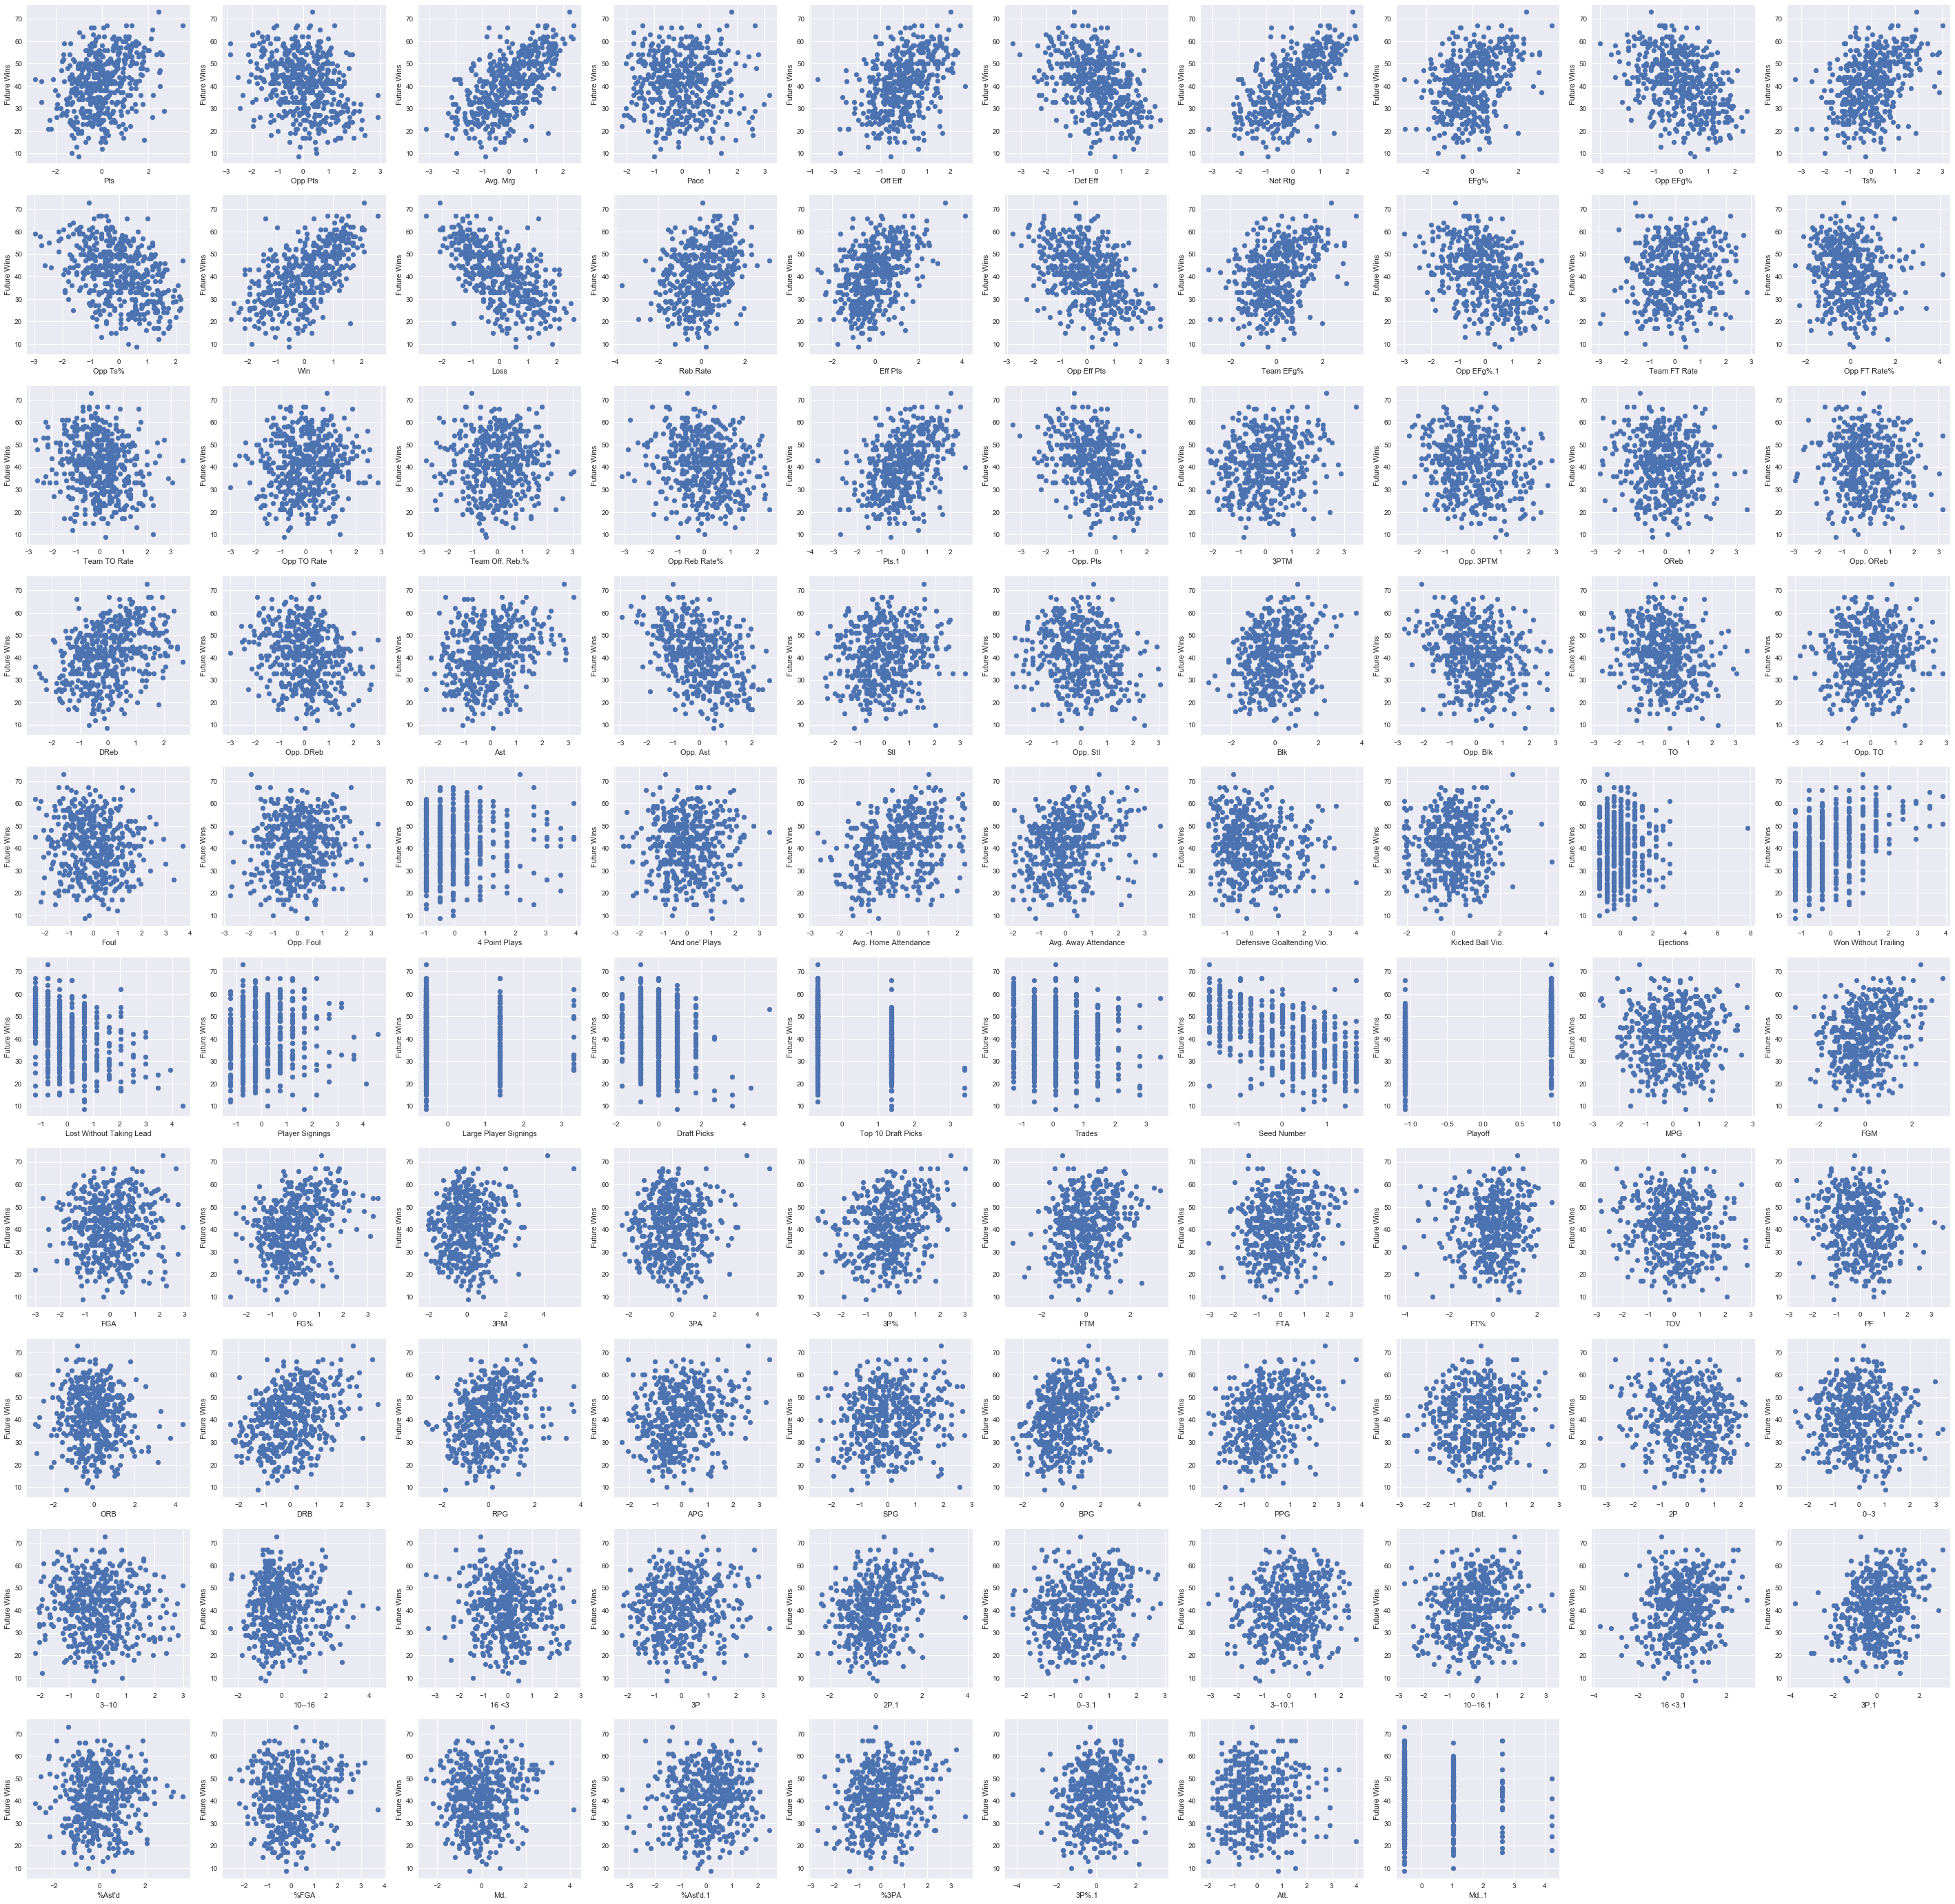

In [16]:
features = train.columns.values.tolist()
counter = 1
fig = plt.figure(figsize=(50,50))
for i in range (0, len(features)):
    temp = fig.add_subplot(10,10,counter)
    temp.scatter(all_examples[features[i]], all_examples['Future Wins'])
    temp.set_xlabel(features[i])
    temp.set_ylabel('Future Wins')
    counter = counter + 1
plt.show()

The graphs above give a better sense through visualization of how each statistic is related to 'Future Wins'. This can be similarly done to the other two ouputs.

Finally, define create_sets so the categories to be dropped do not need to be specified upon calling this function. Instead, based on the target, create_sets will return the sets from helper_create_sets by providing the corresponding list of features to drop with respect to the target.

In [17]:
def create_sets(target, extra_features):
    if target == 'Future Wins':
        train, crossv, test, Y_train, Y_crossv, Y_test, all_examples, next_season = \
            helper_create_sets(drop_categories_1, target, extra_features)
    elif target == 'Future Seed Number':
        train, crossv, test, Y_train, Y_crossv, Y_test, all_examples, next_season = \
            helper_create_sets(drop_categories_2, target, extra_features)
    elif target == 'Future Playoff':
        train, crossv, test, Y_train, Y_crossv, Y_test, all_examples, next_season = \
            helper_create_sets(drop_categories_3, target, extra_features)
    else:
        print("The target is not one of the three possible options")
        
    return train, crossv, test, Y_train, Y_crossv, Y_test, all_examples, next_season

Finally, the functions required to load the data into three sets have been defined and the preprocess steps have taken place. Onwards to obtaining a model!

# <b>Obtaining the Model</b>

Define a helper function to create a table showing each alpha with its respective error and accuracy values for the the cross validation set. This is useful to visualizing whether or not regularization is behaving correctly.

In [18]:
def print_regularization_numbers(alphas, crossv_errors, crossv_accs):
    compare_data = pd.DataFrame({
        'Alpha': alphas,
        'Cross validation error': crossv_errors,
        'Cross validation acc': crossv_accs,
    })
    
    print(compare_data)

Define a function to obtain the best model to fit a data when given a set of possible alphas and the desired output. The model minimizing error should be the same as the model maximizing accuracy. A Ridge linear regression model is used when the model is training on 'Future Wins' or 'Future Seed Number', and a neural networks model is currently used when the model is training on 'Future Playoff'. Note that a simple Logistic Regression model could be used to train on 'Future Playoff'. 25 has been aribitrarily chosen as the number of nodes in the hidden layer because it is slightly more than one half of the features remaining after the preprocess step, or slightly more than one half of the number of input nodes.

alphas: a set of possible values for the regularization term

target: the desired output, i.e. 'Future Wins', 'Future Seed Number', or 'Future Playoff'

In [19]:
def get_best_model(alphas, target, train, crossv, Y_train, Y_crossv):
    
    crossv_errors = []
    crossv_accs = []
    models = []
    
    for curr_alpha in alphas:
        curr_model = linear_model.Ridge(curr_alpha)
        if target == 'Future Playoff':
            curr_model = linear_model.LogisticRegression()
            curr_model = MLPClassifier(solver='lbfgs', alpha = curr_alpha, hidden_layer_sizes=(25), random_state=1)
        
        curr_model.fit(train, Y_train)
        crossv_errors.append(mean_squared_error(Y_crossv, curr_model.predict(crossv)))
        crossv_accs.append(curr_model.score(crossv, Y_crossv))
        models.append(curr_model)

    #optional regularization visualization
    #print_regularization_numbers(alphas, crossv_errors, crossv_accs)
    
    min_index = crossv_errors.index(min(crossv_errors))
    max_index = crossv_accs.index(max(crossv_accs))
    best_model_error = models[min_index]
    best_model_acc = models[max_index]  
    if min_index != max_index:
        print("The model minimizing error is not the same as the model maximizing accuracy")
    
    return best_model_error

Define a function to give a thorough breakdown on the accuracy of a trained model. Prints out a histogram of the differences between the actual outputs and the predictions obtained from the model, in addition to the errors and accuracies for the model on all three sets.

In [20]:
def print_details(best_model, train, crossv, test, Y_train, Y_crossv, Y_test):
    Y_pred = best_model.predict(test)
    diff_error = list(map(operator.sub, Y_pred.tolist(), Y_test.values.tolist()))
    
    #Create a histogram of the differences between the expected values
    #and the actual values
    plt.hist(diff_error, normed=True, bins=30)
    plt.xlabel('Difference')
    plt.ylabel('Frequency')

    #Define errors and accuracy for all sets
    rmse_train = (mean_squared_error(Y_train, best_model.predict(train)))**0.5
    rmse_crossv = (mean_squared_error(Y_crossv, best_model.predict(crossv)))**0.5
    rmse_test = (mean_squared_error(Y_test, best_model.predict(test)))**0.5
    acc_train = best_model.score(train, Y_train)
    acc_crossv = best_model.score(crossv, Y_crossv)
    acc_test = best_model.score(test, Y_test)
    
    plt.show()
    print('*'*70)
    print("Root mean squared error for training set: ", rmse_train)
    print("Root mean squared error for cross validation set: ", rmse_crossv)
    print("Root mean squared error for test set: ", rmse_test)
    print("Accuracy for training set: ", acc_train)
    print("Accuracy for cross validation set: ", acc_crossv)
    print("Accuracy for test set: ", acc_test)
    print('*'*70)

Define the set of possible alphas used to regularize the model.

In [21]:
alphas = [0.001, 0.00183, 0.003, 0.0055, 0.01, 0.0183, 0.03, 0.055, 0.1, 0.183, 0.3, 0.55, 
          1, 1.83, 3, 5.5, 10, 18.3, 30, 55, 100, 183, 300, 550, 1000, 1830, 3000, 5500, 10000]

The following is the list of teams for the 2017-2018 NBA season for which the model attempts to predict win records. This is needed because the 'Teams' category was dropped from the next_season set in order for the model to be applied.

In [22]:
next_season_teams = ["Washington Wizards", "Utah Jazz", "Toronto Raptors", "San Antonio Spurs", 
       "Sacramento Kings", "Portland Trailblazers", "Phoenix Suns", "Philadelphia 76ers", 
       "Orlando Magic", "Oklahoma City Thunder", "New York Knicks", "New Orleans Pelicans", 
       "Minnesota Timberwolves", "Milwaukee Bucks", "Miami Heat", "Memphis Grizzlies", 
       "Los Angeles Lakers", "Los Angeles Clippers", "Indiana Pacers", "Houston Rockets",
       "Golden State Warriors", "Detroit Pistons", "Denver Nuggets", "Dallas Mavericks", 
       "Cleveland Cavaliers", "Chicago Bulls", "Charlotte Hornets", "Brooklyn Nets", 
       "Boston Celtics", "Atlanta Hawks"]

Define the list of corresponding conferences for each franchise in the 2017-2018 NBA season. Mapping teams in the Western conference to 1 and mapping teams in the Eastern conference to 0 helps sort the predictions into the two conferences.

In [23]:
next_season_conferences = ['East','West','East','West',
                           'West','West','West','East',
                           'East','West','East','West',
                           'West','East','East','West',
                           'West','West','East','West', 
                           'West','East','West','West',
                           'East','East','East','East',
                           'East','East']
conference_map = {'West' : 1, 'East': 0}

Create a training, cross validation, and test set, obtain a model for those sets, and demonstrate how effective the model is for predicting the three outputs, based on the alpha values defined.

Model for Future Wins :


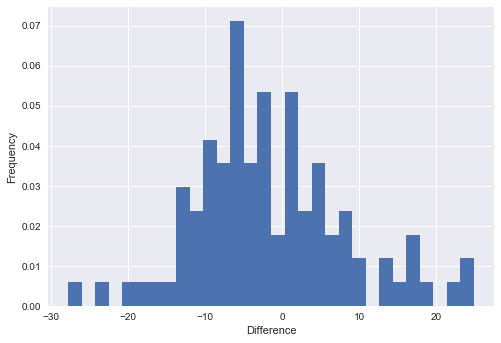

**********************************************************************
Root mean squared error for training set:  8.87800532031
Root mean squared error for cross validation set:  10.3121248488
Root mean squared error for test set:  10.0978412099
Accuracy for training set:  0.443046543655
Accuracy for cross validation set:  0.292177508912
Accuracy for test set:  0.454592052175
**********************************************************************
Model for Future Seed Number :


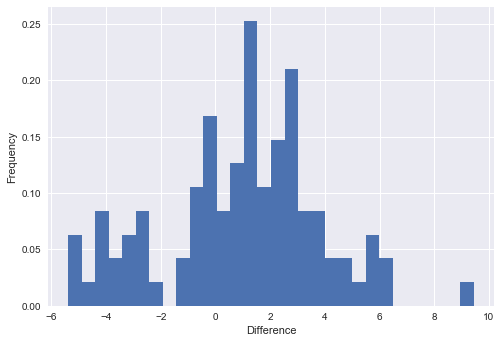

**********************************************************************
Root mean squared error for training set:  3.39709722797
Root mean squared error for cross validation set:  3.56596916785
Root mean squared error for test set:  3.05709105248
Accuracy for training set:  0.401472553777
Accuracy for cross validation set:  0.287773345851
Accuracy for test set:  0.378654268069
**********************************************************************
Model for Future Playoff :


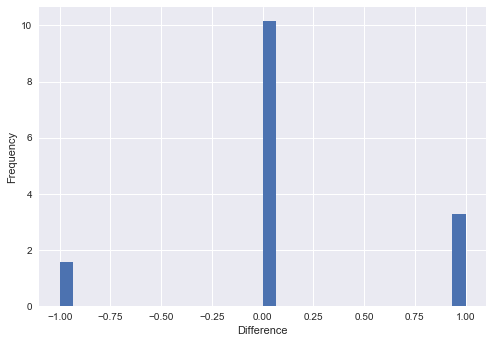

**********************************************************************
Root mean squared error for training set:  0.50777920522
Root mean squared error for cross validation set:  0.540061724867
Root mean squared error for test set:  0.568257570708
Accuracy for training set:  0.742160278746
Accuracy for cross validation set:  0.708333333333
Accuracy for test set:  0.677083333333
**********************************************************************


In [24]:
desired_outputs = ['Future Wins', 'Future Seed Number', 'Future Playoff']
predictions = []
for desired_output in desired_outputs:
    print("Model for", desired_output, ":")
    train, crossv, test, Y_train, Y_crossv, Y_test, all_examples, next_season = \
                                create_sets(desired_output, 'Complex') 
    best_model = get_best_model(alphas, desired_output, train, crossv, Y_train, Y_crossv)
    print_details(best_model, train, crossv, test, Y_train, Y_crossv, Y_test)
    
    predictions_17_18 = pd.DataFrame({
        'Team': next_season_teams,
        'Projected Output': best_model.predict(next_season),
        'Conference': next_season_conferences
    })
    
    predictions.append(predictions_17_18)

Because both the root mean squared errors for the training set and the test set were high and did not differ by much when predicting "Future Wins" and "Future Seed Number", the model seems to be severely underfit for those two. In addition, when predicting "Future Playoff", the accuracy for the training set and the test set were similary close and not significantly high. Thus, the problem most likely lies in the lack of sufficient data. 

# <b>Predicting the 2017-2018 NBA Regular Season</b>

Print out the predictions for the next season.

In [25]:
for i in range(0,3):
    curr_predictions = predictions[i]
    curr_predictions['West'] = curr_predictions['Conference'].map(conference_map)
    curr_predictions = curr_predictions.sort_values(['West','Projected Output'], ascending=[1,0])
    if desired_outputs[i] == 'Future Seed Number':
        curr_predictions = curr_predictions.sort_values(['West','Projected Output'], ascending=[1,1])
    curr_predictions = curr_predictions.drop('West', axis = 1)

    print("The predictions for", desired_outputs[i], "are:  ")
    print(curr_predictions)
    print("*"*100)

The predictions for Future Wins are:  
   Conference  Projected Output                    Team
2        East         46.528339         Toronto Raptors
24       East         46.246789     Cleveland Cavaliers
28       East         45.899896          Boston Celtics
0        East         44.868061      Washington Wizards
14       East         43.594104              Miami Heat
25       East         43.366225           Chicago Bulls
29       East         41.641404           Atlanta Hawks
18       East         41.309104          Indiana Pacers
13       East         40.960659         Milwaukee Bucks
26       East         39.273008       Charlotte Hornets
21       East         37.405285         Detroit Pistons
10       East         36.793466         New York Knicks
27       East         33.878009           Brooklyn Nets
7        East         33.606171      Philadelphia 76ers
8        East         33.230211           Orlando Magic
20       West         60.686189   Golden State Warriors
3        

Again notice that the model refuses to predict distratous or extremely fruitful regular seasons, and at best gives a rough outline for predicting how well each NBA team will do in relation to each other, with respect to the first two metrics of success.

For each season, calculate the standard deviations of each metric of success between the 29 or 30 teams. Also print out the standard deviation and mean of each metric of success for the prediction set.

In [26]:
for i in range(0,3):
    season_years = []
    standard_deviations = []
    for j in range(0,16):
        curr_year = pd.read_csv('/Users/jjia/Desktop/machine_learning/NBA_20' + str(j) + '-' + str(j+1) + '.csv')
        season_years.append(2000 + j)
        standard_deviations.append(curr_year[desired_outputs[i]].std())
    
    spreads = pd.DataFrame({
        'Season': season_years,
        'Deviations': standard_deviations,
    })
    print(spreads)

    print('Prediction spread:', predictions[i]['Projected Output'].std())
    print('Prediction mean:', predictions[i]['Projected Output'].mean())

    Deviations  Season
0    11.310551    2000
1    11.814035    2001
2    11.151553    2002
3    12.137249    2003
4    11.172627    2004
5    10.843717    2005
6    13.826511    2006
7    14.110402    2007
8    13.357163    2008
9    13.175212    2009
10   12.781064    2010
11   12.710255    2011
12   12.913505    2012
13   13.454906    2013
14   13.883754    2014
15   11.188048    2015
Prediction spread: 6.57573117979842
Prediction mean: 41.50369468930019
    Deviations  Season
0     4.264933    2000
1     4.264933    2001
2     4.264933    2002
3     4.320874    2003
4     4.394354    2004
5     4.394354    2005
6     4.394354    2006
7     4.394354    2007
8     4.394354    2008
9     4.394354    2009
10    4.394354    2010
11    4.394354    2011
12    4.394354    2012
13    4.394354    2013
14    4.394354    2014
15    4.394354    2015
Prediction spread: 2.26631092105154
Prediction mean: 8.111559546796734
    Deviations  Season
0     0.506120    2000
1     0.506120    2001
2     0

From the above data and in conjunction to the earlier analysis, the model obtained seems to be severely underfit. Whereas the spread from the stats of other NBA seasons averaged about 12 or 13 wins, the win predictions for the upcoming 2017-2018 NBA season was much less, meaning the model preferred to predict wins closer to the mean because the algorithm was not accurate enough to correctly predict teams that did much better or much worse than average. Similarly when looking at "Future Seed Number", normal seasons exhibited a standard deviation of around 4 while the predicted seed numbers only exhibited a standard deviation of around 2.

Define a function to obtain sets and create models for many iterations to estimate the average training set and test set errors and accuracies.

In [27]:
def do_multiple_iterations(iterations, target, extra_features):
    training_errors = []
    testing_errors = []
    training_accs = []
    testing_accs = []

    for i in range (0, iterations):
    
        if (i % int(iterations/10) == 0):
            print('Working...  Progress: ', i, '%.....')

        train, crossv, test, Y_train, Y_crossv, Y_test, all_examples, next_season \
                              = create_sets(target, extra_features) 

        model = get_best_model(alphas, target, train, crossv, Y_train, Y_crossv)

        training_errors.append(mean_squared_error(Y_train, model.predict(train))**0.5)
        testing_errors.append(mean_squared_error(Y_test, model.predict(test))**0.5)
        training_accs.append(model.score(train, Y_train))
        testing_accs.append(model.score(test, Y_test))
    
    print("Average training error is: ", sum(training_errors)/len(training_errors)) 
    print("Average testing error is: ", sum(testing_errors)/len(testing_errors)) 
    print("Average training acc is: ", sum(training_accs)/len(training_accs)) 
    print("Average testing acc is: ", sum(testing_accs)/len(testing_accs)) 
    print("Maximum testing error is: ", max(testing_errors))
    print("Minimum testing acc is: ", min(testing_accs))

Now run the function for all three possible outputs.

In [28]:
do_multiple_iterations(100, 'Future Wins', 'Complex')

Working...  Progress:  0 %.....
Working...  Progress:  10 %.....
Working...  Progress:  20 %.....
Working...  Progress:  30 %.....
Working...  Progress:  40 %.....
Working...  Progress:  50 %.....
Working...  Progress:  60 %.....
Working...  Progress:  70 %.....
Working...  Progress:  80 %.....
Working...  Progress:  90 %.....
Average training error is:  9.22024570196
Average testing error is:  9.61055585676
Average training acc is:  0.442560216602
Average testing acc is:  0.381859666089
Maximum testing error is:  11.380743036
Minimum testing acc is:  0.172405718352


In [29]:
do_multiple_iterations(100, 'Future Seed Number', 'Complex')

Working...  Progress:  0 %.....
Working...  Progress:  10 %.....
Working...  Progress:  20 %.....
Working...  Progress:  30 %.....
Working...  Progress:  40 %.....
Working...  Progress:  50 %.....
Working...  Progress:  60 %.....
Working...  Progress:  70 %.....
Working...  Progress:  80 %.....
Working...  Progress:  90 %.....
Average training error is:  3.31530933541
Average testing error is:  3.48533516564
Average training acc is:  0.402008728456
Average testing acc is:  0.336580373394
Maximum testing error is:  4.06304684446
Minimum testing acc is:  0.178216164048


In [31]:
do_multiple_iterations(100, 'Future Playoff', 'none')

Working...  Progress:  0 %.....
Working...  Progress:  10 %.....
Working...  Progress:  20 %.....
Working...  Progress:  30 %.....
Working...  Progress:  40 %.....
Working...  Progress:  50 %.....
Working...  Progress:  60 %.....
Working...  Progress:  70 %.....
Working...  Progress:  80 %.....
Working...  Progress:  90 %.....
Average training error is:  0.483836034587
Average testing error is:  0.542402695707
Average training acc is:  0.751304594855
Average testing acc is:  0.703958333333
Maximum testing error is:  0.669265766842
Minimum testing acc is:  0.552083333333


The above statistics should give a rough measure on how well each model does on predicting each possible metric of success. None of the three predict test sets to extreme accuracy, and the model for 'Future Playoff' proves to be the most successful of the three, achieving around a 70% accuracy in determining whether or not a team will make the playoffs. However, even the model training 'Future Playoff' caps out around 70%. When run with 30, 25, 20, or 15 hidden neurons, the testing accuracy never increased significantly and did not show more promise amongst the cases. Even when more hidden layers were added to the neural network, only the training accuracy would improve. In some cases with additional hidden layers, the test case accuracy worsened. Thus, only one hidden layer is needed, and 25 hidden neurons were ultimately decided upon as the most optimal number of nodes.

# <b>Summary</b>

It seems as though the machine learning algorithms can only the train the current datasets to a certain extent, until underfitting becomes a problem. In the models for 'Future Wins' and 'Future Seed Number', the root mean square errors were high for both the training sets and the test sets, meaning the models were underfit. Even in the model for 'Future Playoff', only the training accuracy could be improved significantly. Thus, the majority of the problem should lie within the datasets. Some other features that could be added to improve each model that have not already been added to the datasets include: number of all stars on each team, number of veterans, number of championships in the most recent years, the salary distribution of each team with respect to the salary cap, the distribution of talent amongst positions for each team, wins in respective conference, wins in respective division, conference rank, division rank, home wins, away wins, number of top win shares players, and in general other statistics that could quantify a team's roster as having a higher chance of success or a higher chance of failure upon the next regular season. However, these features currently lie outside the scope of this project, and this notebook will halt here, but these features could very well be later added  into the datasets.
